Initial weights are randomized because otherwise the hidden layers revcieve the same information. It is impossible for the model to learn.

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)
torch.set_printoptions(sci_mode=False)

In [2]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  z = 1/(1+(torch.exp(-z)))

  return z

In [3]:
# sigmoid derivative
def sigmoid_der(z: torch.Tensor) -> torch.Tensor:
  z = sigmoid(z)*(1-sigmoid(z))
  return z

In [4]:
## logistic regression class from prior assignment
#added the random_weights input to allow model to start with random values for weights
class LogisticRegression(nn.Module):
  def __init__(self, num_features, random_weights, seed=None):
    super().__init__()
    if random_weights:
      #random seed declared in node creation for reproducability
      torch.random.manual_seed(seed)
      #variables are selected from a uniform distirbution with a relatively wide range
      self.weight = nn.Parameter(torch.empty(1, num_features).normal_(mean = 0,std = 1), requires_grad=False)

    else:
      self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = torch.matmul(self.weight,x.T).T
    y_sig = sigmoid(y)
    return y_sig

Creating and Visualizing XoR

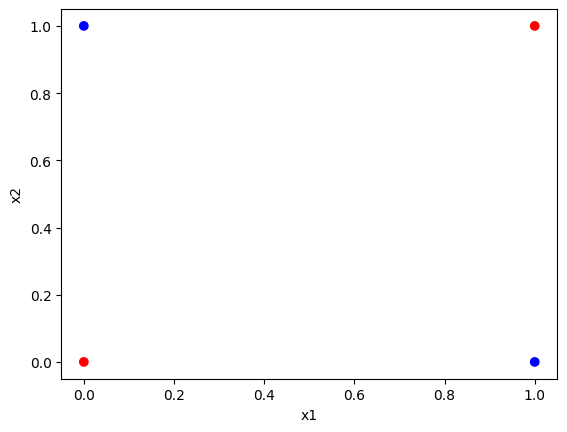

In [5]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Forward and Backward Steps

In [6]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs, seed=42):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs, True, seed + i) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1, True, seed + num_inputs + i) for i in range(num_outputs)]) # +1 for the bias

  def forward(self, x: torch.tensor) -> torch.tensor:
    y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
    #note: may want to generalize to ouputs of different dimensionality
    output = torch.ones(len(self.output_layer))

    #start by taking the inputs and calcutaing the output of a logistic model
    for index, model in enumerate(self.hidden_layer):
      y_hidden[index] = model(x)

    #generalized for multiple outputs
    for index, model in enumerate(self.output_layer):
      output[index] = model(y_hidden)

    return output

  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
    #x is a vector of length d where d is the number of attributes in the input data
    #y is a vector of length d where d is the number of output nodes

    #y_hidden is a vector of length d where d is the number of nodes in the hidden layer + 1 (bias)
    #(1,i) is the output value of node i in the hidden layer
    y_hidden = torch.ones(len(self.hidden_layer) + 1)

    #pred is a vector of length d where d is equal to the number of nodes in the ouptut layer
    #(1,i) is the solution returned in node_i
    pred = torch.ones(len(self.output_layer))

    #w_hid is a nxm matrix of the weights in the hidden layer
    #Where n = the number of nodes in the hidden layer
    #and m = the number of dimensions in the input data
    #note that row i of w_hid is the weights corresponding to node i
    #(i,j) is the weight thats applied to the jth element of the input data in the output of node i
    #can be phrased as the weight that connects the jth element in the input data to the ith nueron in the hidden layer
    w_hid = []

    #x_hid is a 1xd vecotor of length where d is equal to the number of nodes in the hidden layer plus the bias
    #an element (1,i) in x_hid is the input pre-activiation into node i in the hidden layer
    x_hid = []

    #w_out is a nxm matrix of the weights in the output layer
    #n is the number of nodes in the output layer
    #m is the number of outputs in the hidden layer
    #row i corresponds to the weights associated with node i
    #(i,j) is the weight applied to the jth element of the hidden layer outputs in the prediction produced by node i
    #the weight that connects the jth element of the hidden layer to the ith element of the output layer
    w_out =[]

    #x_out is a vector of length d where d is the number of nodes in the output layer
    #an element i in a_out corresponds to the input preactivation into node i in the output layer
    x_out = []

    for index, model in enumerate(self.hidden_layer):
      y_hidden[index] = model(x)
      w_hid.append(model.weight[0])

      inp_to_act = torch.dot(x, model.weight[0])
      x_hid.append(inp_to_act)

    for index, model in enumerate(self.output_layer):
      pred[index] = model(y_hidden)
      w_out.append(model.weight[0])

      inp_to_act = torch.dot(y_hidden, model.weight[0])
      x_out.append(inp_to_act)


    w_hid = torch.stack(w_hid)
    w_out = torch.stack(w_out)
    x_hid = torch.stack(x_hid)
    x_out = torch.stack(x_out)

    #step 1
    #calcuate deltas of output layer

    #subtract elements from model predictions and multiply element wise with the
    # pred, y and a_out are all vectors with length equal to the number of output neurons
    out_deltas = (pred - y) * sigmoid_der(x_out)


    #Step 2
    #calculate deltas associated with each node in the hidden layer

    #d is the number of nodes in the hidden layer
    #sigmoid_der(al_hid) is d length vector
    #want a vector x of length d such that element i in x is the dot product of the weights
    #that connect i to every j in the output layer and the deltas of j in out_deltas

    #remove bias from calcuation
    hidden_deltas = sigmoid_der(x_hid) * torch.sum(w_out[:,:-1] * out_deltas, dim=0)




    #step 3
    #update weights in output layer
    #need to redo, currently using al

    #w_out is a matrix of cxd where c is the number of out neurons and d is the number of hidden neur
    #weight (i, j) in w_out connects hidden layer j to out layer i
    #y_hidden is a vector of length d containing outputs alpha of the hidden layer of neurons
    #out_deltas a vector of length c containg deltas associated with the output layer
    #we want to compute delta_i * al_j for each weight i,j
    #where al_j is the output of the jth hidden neuron
    #and delta_i is the delta of the ith output neuron

    #simple generalization of matrix mutliplication shows that the product of out_deltas (cx1) and y_hidden (1xd)
    #returns a cxd matrix, where each element is i,j is delta_i * al_j

    w_out = w_out - lr* torch.matmul(out_deltas.reshape(-1,1), y_hidden.reshape(1,-1))


    for index, model in enumerate(self.output_layer):
      new_weights = model.weight

      new_weights[0] = w_out[index,:]
      model.weight = nn.Parameter(new_weights, requires_grad=False)

    #step 4
    #update hidden weights

    w_hid = w_hid - lr*torch.matmul(hidden_deltas.reshape(-1,1), x.reshape(1,-1))

    #print(w_hid)

    for index, model in enumerate(self.hidden_layer):
      new_weights = model.weight

      new_weights[0] = w_hid[index,:]
      model.weight = nn.Parameter(new_weights, requires_grad=False)


In [7]:
#BCE function
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  ### your code here
  N = y_true.shape[0]

  y_pred = y_pred.float()
  y_true = y_true.float()

  #same code from last week
  bce_val_t1 = -1*torch.matmul(y_true.T,torch.log(y_pred))
  bce_val_t2 = -1*torch.log(torch.ones(N,1) - y_pred).sum().reshape(1,1)
  bce_val_t3 = torch.matmul(y_true.T, torch.log(torch.ones(N,1)-y_pred) )
  bce_val = bce_val_t1 + bce_val_t2 + bce_val_t3

  bce_val = bce_val/N
  return bce_val

Training Loop

torch.Size([4, 3])


<ipython-input-4-458d8f268df4>:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  y = torch.matmul(self.weight,x.T).T
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/pyt

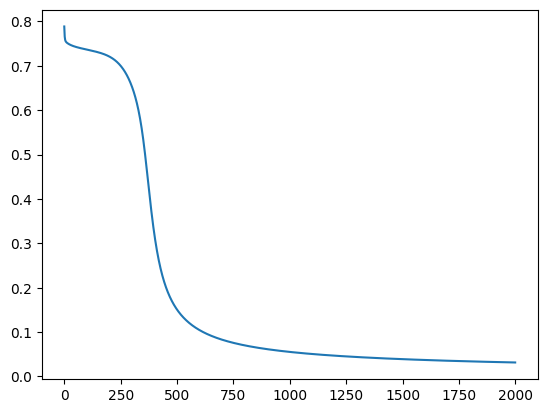

tensor([0., 1., 1., 0.]) tensor([0.0286, 0.9676, 0.9675, 0.0305])


In [8]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 1
iterations = 2000
#added seed parameter to adjust state of random weights
#all seeds I have tested have converged
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1, seed=1231244)

errors = list()
predictions = []
for ep in range(iterations):
  error = 0
  #print('Iteration : {}'.format(ep+1))
  for i in range(x.shape[0]):
    y_train = y[i].reshape(1,)
    x_train = x[i]

    y_pred = model(x_train)
    error += bce(y_train, y_pred)
    model.backward_pass(x[i], y_train, lr)
  errors.append(error/x.shape[0])

  y_pred = torch.zeros_like(y)
  for i in range(x.shape[0]):
    y_pred[i] = model(x[i])
  predictions.append(y_pred.T)

plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
  y_pred[i] = model(x[i])
print(y, y_pred)

Higher Level NN implimentation. Multiclass classifcation of the Iris dataset

In [9]:
iris = datasets.load_iris(as_frame=True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

In [11]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  z = (x-mu)/sigma
  return z

x_train_mu = x_train.mean(dim=0,keepdim=True)
x_train_sigma = x_train.std(dim=0,keepdim=True)

x_train = norm_set(x_train,x_train_mu,x_train_sigma)
x_test = norm_set(x_test, x_train_mu,x_train_sigma)

In [12]:
y_train = y_train.long()
y_test = y_test.long()

Define Training loop

In [13]:
# train loop
def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(10000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    #using cross entropy as opposed to binary cross entropy because this is no longer a problem of binary classes
    #Automatically applies softmax when error is calculated, so model output is non-normalized
    cost = F.cross_entropy(pred, y.reshape(-1), reduction='mean')
    cost.backward()
    train_lst.append(cost.item())

    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.cross_entropy(test_pred, test_y.reshape(-1), reduction='mean')
      test_lst.append(test_cost.item())
  fig, axs = plt.subplots(2)
  num_hidden_nodes = model[0].out_features

  fig.suptitle('Number of Nodes: {}'.format(num_hidden_nodes))
  axs[0].plot(list(range(i+1)), train_lst)
  axs[0].title.set_text('Train Error')
  axs[1].plot(list(range(i+1)), test_lst)
  axs[1].title.set_text('Test Error')
  plt.tight_layout()
  plt.show()

  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


In [14]:
#Function used to compute accuracy of outputs for summary
def compute_accuracy(true, pred, train_test):
  sm = nn.Softmax(dim=1)
  pred = sm(pred)
  predictions = torch.max(pred, dim = 1)[1].reshape(-1,1)

  comp_accuracy = torch.hstack((predictions, true))

  num_accurate_pred = 0
  for row in comp_accuracy:
    if row[0] == row[1]:
      num_accurate_pred += 1

  print('number of accurate predictions with {0} data: {1}'.format(train_test ,num_accurate_pred))
  print('percentage of accurate predictions with {0} data: {1}'.format(train_test,num_accurate_pred/true.shape[0]))


In [15]:
### Model Creation
neuron_counts = [1,2,4,8,16,32]
models = []

for val in neuron_counts:
  model = nn.Sequential(
                        nn.Linear(x_train.shape[1], val, bias=True),
                        nn.Sigmoid(),
                        nn.Linear( val, 3, bias=True)
                        #cross entropy loss error function requires un-normalized data as ouput as
                        #softmax is applied when the error is calculated
                        )
  models.append(model)

In [16]:
print(y_train.unique(return_counts=True))

(tensor([0, 1, 2]), tensor([40, 41, 39]))


Training NN for class 1 with multiple hidden layer sizes

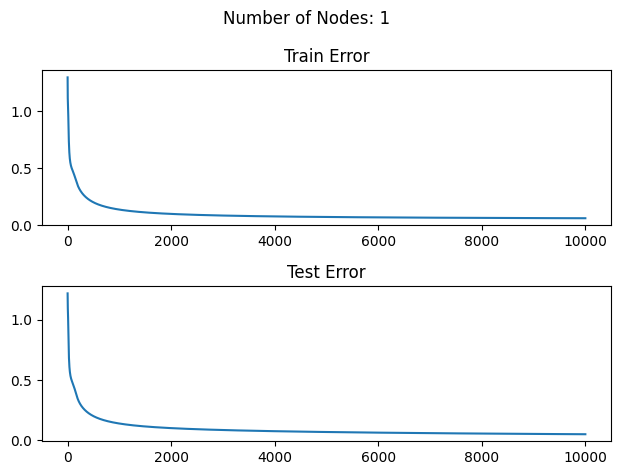

Minimum train cost: 0.06059245392680168
Minimum test cost: 0.04834204167127609
number of accurate predictions with Train data: 117
percentage of accurate predictions with Train data: 0.975
number of accurate predictions with Test data: 30
percentage of accurate predictions with Test data: 1.0


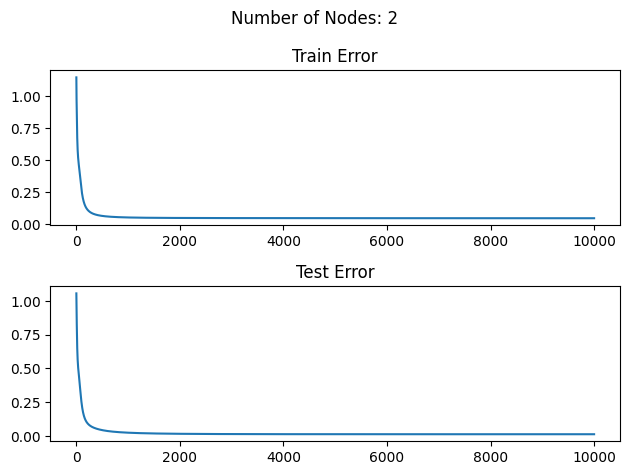

Minimum train cost: 0.0477520115673542
Minimum test cost: 0.015075203962624073
number of accurate predictions with Train data: 118
percentage of accurate predictions with Train data: 0.9833333333333333
number of accurate predictions with Test data: 30
percentage of accurate predictions with Test data: 1.0


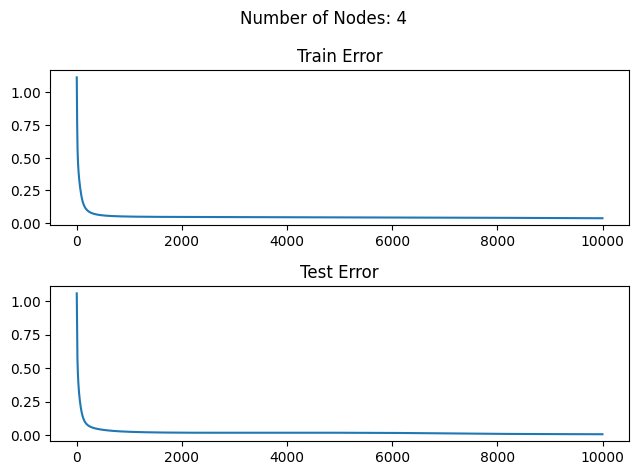

Minimum train cost: 0.03821294382214546
Minimum test cost: 0.00622097123414278
number of accurate predictions with Train data: 118
percentage of accurate predictions with Train data: 0.9833333333333333
number of accurate predictions with Test data: 30
percentage of accurate predictions with Test data: 1.0


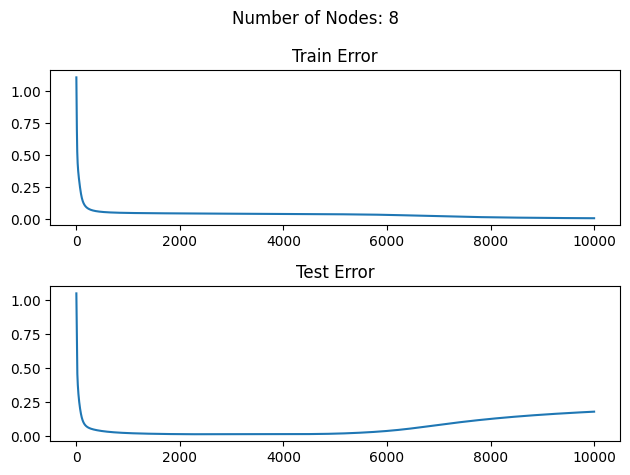

Minimum train cost: 0.00832811277359724
Minimum test cost: 0.016268976032733917
number of accurate predictions with Train data: 120
percentage of accurate predictions with Train data: 1.0
number of accurate predictions with Test data: 28
percentage of accurate predictions with Test data: 0.9333333333333333


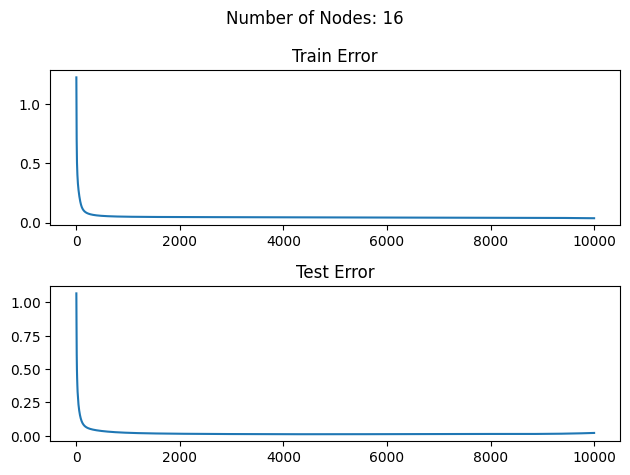

Minimum train cost: 0.036621950566768646
Minimum test cost: 0.012406870722770691
number of accurate predictions with Train data: 118
percentage of accurate predictions with Train data: 0.9833333333333333
number of accurate predictions with Test data: 30
percentage of accurate predictions with Test data: 1.0


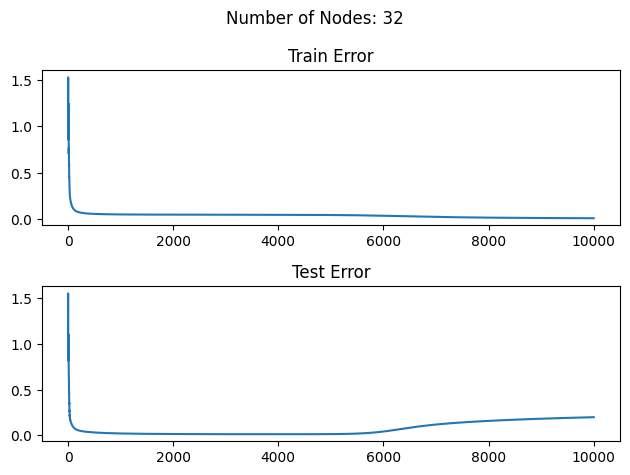

Minimum train cost: 0.007766430266201496
Minimum test cost: 0.013784616254270077
number of accurate predictions with Train data: 120
percentage of accurate predictions with Train data: 1.0
number of accurate predictions with Test data: 29
percentage of accurate predictions with Test data: 0.9666666666666667


In [17]:
alpha = 1
for model in models:
  optimiser = optim.SGD(model.parameters(), alpha)
  train(model, x_train, y_train, x_test, y_test, optimiser, alpha)
  pred_train = model(x_train)
  compute_accuracy(y_train , pred_train, 'Train')

  pred_test = model(x_test)
  compute_accuracy(y_test , pred_test, 'Test')